In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp "/content/drive/My Drive/kaggle.json" ~/.kaggle/
!kaggle datasets download -d dmitrybabko/speech-emotion-recognition-en -p /content/drive/MyDrive/assignment3

In [ ]:
!unzip '/content/drive/MyDrive/assignment3/speech-emotion-recognition-en.zip' -d '/content/drive/MyDrive/assignment3'

In [17]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow import keras
from PIL import Image
from numpy import asarray
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.utils import array_to_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Conv1D, MaxPool1D, Input, Dropout, GlobalMaxPooling1D, MaxPooling1D, Dense
from tensorflow.keras import activations, optimizers, losses
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
#classifying according to emotion


# Define a list of emotions
emotions = ['ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD']

# Path to directory containing audio files
audio_path = '/content/drive/MyDrive/assignment3/Crema'

# Create a dictionary to store the file paths for each emotion
emotion_files = {e: [] for e in emotions}
# Loop over each audio file in directory
for audio_file_name in os.listdir(audio_path):
    # Check if file is a WAV file
    if audio_file_name.endswith('.wav'):
        # Extract the emotion from file name
        file_parts = audio_file_name.split('_')
        emotion = file_parts[2]

        # Check if the emotion is valid
        if emotion in emotions:
            # Construct path to audio file
            audio_file_path = os.path.join(audio_path, audio_file_name)
            
            # Add the file path to the list of files for this emotion
            emotion_files[emotion].append(audio_file_path)
            
# Print the number of files for each emotion
for emotion, files in emotion_files.items():
    print(f'{emotion}: {len(files)}')


ANG: 1271
DIS: 1271
FEA: 1271
HAP: 1271
NEU: 1087
SAD: 1271


In [4]:
def calculate_energy(audio_array, frame_length):
    squared_values = np.square(audio_array)
    sum_of_squares = np.sum(squared_values)
    normalized_energy = sum_of_squares / frame_length
    return normalized_energy

In [ ]:
# for emotion in emotions:
#     # Get the file paths for this emotion
#     emotion_file = [os.path.join(audio_path, f) for f in os.listdir(audio_path) if f.endswith('.wav') and f.split('_')[2] == emotion]
    
#     # Load and plot the audio for this emotion
#     for file_path in emotion_file:
#         # Load audio file
#         audio, sr = librosa.load(file_path, sr=None)


#         mfcc = librosa.feature.mfcc(y=audio,sr=sr)
#         stft = np.abs(librosa.stft(audio))
#         zcr = librosa.feature.zero_crossing_rate(audio)
#         f0 = librosa.yin(audio, fmin=80, fmax=400, sr=sr)
#         f0=f0.reshape(1,f0.shape[0])
#         spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=sr)

#         print("STFT shape:", stft.shape)
#         print("MFCC shape:", mfcc.shape)
#         print("ZCR shape:", zcr.shape)
#         print("Pitch shape:", f0.shape)
#         print("Spectral Centroid shape:", spectral_centroids.shape)

#         # max_length = max(mfcc.shape[1], stft.shape[1], zcr.shape[1], f0.shape[1], spectral_centroids.shape[1])
#         max_length =158
#         mfcc = np.pad(mfcc, ((0, 0), (0, max_length - mfcc.shape[1])), mode='constant')
#         stft = np.pad(stft, ((0, 0), (0, max_length - stft.shape[1])), mode='constant')
#         zcr = np.pad(zcr, ((0, 0), (0, max_length - zcr.shape[1])), mode='constant')
#         f0 = np.pad(f0, ((0, 0), (0, max_length - f0.shape[1])), mode='constant')

#         # print(f'aaaaaaaaaaaa{max_length}aaaaaaa{f0.shape[0]}')
#         # if f0.shape[0] < max_length:
#         #   f0 = np.pad(f0, ((0, 0), (0, max_length - f0.shape[1])) , mode='constant')
#         # elif f0.shape[0] > max_length:
#         #   f0 = f0[:, :max_length]
#         spectral_centroids = np.pad(spectral_centroids, ((0, 0), (0, max_length - spectral_centroids.shape[1])), mode='constant')


#         print("STFT shape:", stft.shape)
#         print("MFCC shape:", mfcc.shape)
#         print("ZCR shape:", zcr.shape)
#         print("Pitch shape:", f0.shape)
#         print("Spectral Centroid shape:", spectral_centroids.shape)


#         mfcc_normalized = (mfcc - np.mean(mfcc)) / np.std(mfcc)
#         stft_normalized = (stft - np.mean(stft)) / np.std(stft)
#         zcr_normalized = (zcr - np.mean(zcr)) / np.std(zcr)
#         f0_normalized = (f0 - np.mean(f0)) / np.std(f0)
#         spectral_centroids_normalized = (spectral_centroids - np.mean(spectral_centroids)) / np.std(spectral_centroids)


#         # features = np.vstack((np.transpose(mfcc_normalized), zcr_normalized, stft_normalized, f0_normalized,spectral_centroids_normalized)).transpose()
#         features1 = np.vstack((mfcc_normalized, zcr_normalized, stft_normalized, f0_normalized, spectral_centroids_normalized)).T
#         print(features1.shape)

In [11]:
from librosa.feature.spectral import zero_crossing_rate
# Path to directory containing audio files
audio_path = '/content/drive/MyDrive/assignment3/Crema'

data = pd.DataFrame(columns=['emotion', 'mel_spec_db', 'features1'])
smallest=100
mel_spec_db=0

# Loop over each emotion in list
for emotion in emotions:
    # Get the file paths for this emotion
    emotion_file = [os.path.join(audio_path, f) for f in os.listdir(audio_path) if f.endswith('.wav') and f.split('_')[2] == emotion]
    # Load and plot the audio for this emotion
    i=0
    for file_path in emotion_file:
        i=i+1
        if i>100:
          break
        # Load audio file
        audio, sr = librosa.load(file_path, sr=None)
        # audio = np.concatenate([audio,audio,audio,audio])
        audio=audio[:20000]

        mfcc = librosa.feature.mfcc(y=audio,sr=sr)
        stft = np.abs(librosa.stft(audio))
        zcr = librosa.feature.zero_crossing_rate(audio)
        f0 = librosa.yin(audio, fmin=80, fmax=400, sr=sr)
        f0=f0.reshape(1,f0.shape[0])
        spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=sr)
      

        # print("STFT shape:", stft.shape)
        # print("MFCC shape:", mfcc.shape)
        # print("ZCR shape:", zcr.shape)
        # print("Pitch shape:", f0.shape)
        # print("Spectral Centroid shape:", spectral_centroids.shape)
        # if stft.shape[1]<smallest:
        #   smallest=stft.shape[1]
        # print(smallest)

        # max_length = max(mfcc.shape[1], stft.shape[1], zcr.shape[1], f0.shape[1], spectral_centroids.shape[1])
        # max_length =158
        # mfcc = np.pad(mfcc, ((0, 0), (0, max_length - mfcc.shape[1])), mode='constant')
        # stft = np.pad(stft, ((0, 0), (0, max_length - stft.shape[1])), mode='constant')
        # zcr = np.pad(zcr, ((0, 0), (0, max_length - zcr.shape[1])), mode='constant')
        # f0 = np.pad(f0, ((0, 0), (0, max_length - f0.shape[1])), mode='constant')
        # spectral_centroids = np.pad(spectral_centroids, ((0, 0), (0, max_length - spectral_centroids.shape[1])), mode='constant')


        # print("STFT shape:", stft.shape)
        # print("MFCC shape:", mfcc.shape)
        # print("ZCR shape:", zcr.shape)
        # print("Pitch shape:", f0.shape)
        # print("Spectral Centroid shape:", spectral_centroids.shape)


        mfcc_normalized = (mfcc - np.mean(mfcc)) / np.std(mfcc)
        stft_normalized = (stft - np.mean(stft)) / np.std(stft)
        zcr_normalized = (zcr - np.mean(zcr)) / np.std(zcr)
        f0_normalized = (f0 - np.mean(f0)) / np.std(f0)
        spectral_centroids_normalized = (spectral_centroids - np.mean(spectral_centroids)) / np.std(spectral_centroids)


        # features = np.vstack((np.transpose(mfcc_normalized), zcr_normalized, stft_normalized, f0_normalized,spectral_centroids_normalized)).transpose()
        # features1 = np.vstack((mfcc_normalized, zcr_normalized, stft_normalized, f0_normalized, spectral_centroids_normalized)).T
        features1=np.concatenate((mfcc_normalized.flatten(),stft_normalized.flatten(),zcr_normalized.flatten(),f0_normalized.flatten(),spectral_centroids_normalized.flatten()),axis=0)
        print(f'feature1 shape:{features1.shape}')
        # features1=np.reshape(features1, (1, 41920, 1))
        print(f'feature1 shape:{features1.shape}')


        frame_length = len(audio)
        energy = calculate_energy(audio, frame_length)
        # print(energy)

                              # mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr)
                              # mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

        # signs = np.sign(audio)
        # signs[signs == 0] = -1

        # zero_crossing_rate= len(np.where(np.diff(signs))[0])/len(audio)

        # hena el mfrood na5od el data nsayevha fe 7etta 
        # 3andena el label (emotion) w features (mel_spec_db w zero_crossing_rate)
        temp='no'
        ['ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD']
        for j in range(6):
          if emotion==emotions[j]:
            temp=j

        np.set_printoptions(threshold=np.inf)
        data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)
        # print(np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']'))

        # Display the mel spectrogram

        # plt.figure(figsize=(10, 4))
        # librosa.display.specshow(mel_spec_db, x_axis='time', y_axis='mel', sr=sr)
        # plt.colorbar(format='%+2.0f dB')
        # plt.title('Mel spectrogram')
        # plt.tight_layout()
        # plt.show()


        # Plot waveform

        # plt.figure()
        # plt.title(f'Waveform for {emotion}: {file_path}')
        # plt.xlabel('Time (s)')
        # plt.ylabel('Amplitude')
        # plt.plot(audio)
        # plt.show()


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


feature1 shape:(41920,)
feature1 shape:(41920,)


<ipython-input-11-0bbfc9674b69>:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append({'emotion': temp, 'mel_spec_db': mel_spec_db, 'features1': np.array2string(features1, separator=',',threshold=np.inf, prefix='[', suffix=']')}, ignore_index=True)


In [12]:
# Save DataFrame to CSV file
data.to_csv('audio_features.csv', index=False)

In [13]:
# Load the data
data = pd.read_csv('audio_features.csv')

# Split the data into training/validation and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(data['features1'], data['emotion'], test_size=0.3, random_state=42, stratify=data['emotion'])

# print(type(np.array(X_train_val.iloc[3])[0]))

# Further split the training/validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.05, random_state=42, stratify=y_train_val)


In [ ]:
print(data['features1'][0].shape)

In [ ]:
# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Reshape((41920, 1), input_shape=(41920,)))  # Reshape the input to (41920, 1)
# model.add(tf.keras.layers.Conv1D(32, 1000, activation='relu'))
# model.add(tf.keras.layers.MaxPooling1D(2))
# model.add(tf.keras.layers.Conv1D(64, 10, activation='relu'))
# model.add(tf.keras.layers.MaxPooling1D(2))
# model.add(tf.keras.layers.Conv1D(128, 10, activation='relu'))
# model.add(tf.keras.layers.GlobalAveragePooling1D())
# model.add(tf.keras.layers.Dense(1, activation='sigmoid'))



# model.compile(loss='binary_crossentropy', optimizer='sgd', metrics='accuracy')
# model.summary()

In [ ]:
# model = Sequential()
# model.add(tf.keras.layers.Reshape((41920, 1), input_shape=(41920,)))
# model.add(Conv1D(128, 3, activation='relu'))
# model.add(Conv1D(128, 3, activation='relu'))
# model.add(MaxPooling1D(pool_size=3, strides=1))
# model.add(Conv1D(256, 3, activation='relu'))
# model.add(MaxPooling1D(pool_size=3, strides=1))
# model.add(Conv1D(256, 3, activation='relu'))
# model.add(MaxPooling1D(pool_size=3, strides=1))
# model.add(Conv1D(256, 3, activation='relu'))
# model.add(MaxPooling1D(pool_size=3, strides=1))
# model.add(Conv1D(256, 3, activation='relu'))
# model.add(MaxPooling1D(pool_size=3, strides=1))
# model.add(Conv1D(256, 3, activation='relu'))
# model.add(MaxPooling1D(pool_size=3, strides=1))
# model.add(Conv1D(512, 3, activation='relu'))
# model.add(MaxPooling1D(pool_size=3, strides=1))
# model.add(Conv1D(512, 1, activation='relu'))
# model.add(Dense(10, activation='softmax'))
# model.compile(loss='binary_crossentropy', optimizer='sgd', metrics='accuracy')


In [15]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
new_val=np.zeros((X_val.shape[0],41920))
i=0
for tupl in X_val:
  tupl=tupl.replace('\n', '')
  tupl=tupl.replace(' ', '')
  tup= tupl.strip('[]').split(',')
  new_val[i]=np.array(tup)
  i=i+1
new_val = np.array([[float(element) for element in row] for row in new_val])
new_y_val= np.array(y_val).reshape(-1, 1)
new_y_val = np.array([[float(element) for element in row] for row in new_y_val])


new_train=np.zeros((X_train.shape[0],41920))
i=0
for tupl in X_train:
  tupl=tupl.replace('\n', '')
  tupl=tupl.replace(' ', '')
  tup= tupl.strip('[]').split(',')
  new_train[i]=np.array(tup)
  i=i+1
new_train = np.array([[float(element) for element in row] for row in new_train])
new_y_train= np.array(y_train).reshape(-1, 1)
new_y_train = np.array([[float(element) for element in row] for row in new_y_train])
# label_encoder = LabelEncoder()
# label_encoder.fit(new_y_train)
# numbers = label_encoder.transform(new_y_train)

# model.fit(new_train, numbers, epochs=1000)
# model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
# model.fit(new_train, np.array(y_train), epochs=10)
# model.fit(new_train, np.array(y_train), epochs=10, validation_data=(X_val, y_val))

In [27]:
#best 23
nclass = 6
inp = Input(shape=(41920, 1))
img_1 = Conv1D(16, kernel_size=9, activation=activations.relu, padding="valid")(inp)
img_1 = Conv1D(16, kernel_size=9, activation=activations.relu, padding="valid")(img_1)
img_1 = MaxPool1D(pool_size=16)(img_1)
img_1 = Dropout(rate=0.1)(img_1)
img_1 = Conv1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
img_1 = Conv1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
img_1 = MaxPool1D(pool_size=4)(img_1)
img_1 = Dropout(rate=0.1)(img_1)
img_1 = Conv1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
img_1 = Conv1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
img_1 = MaxPool1D(pool_size=4)(img_1)
img_1 = Dropout(rate=0.1)(img_1)
img_1 = Conv1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
img_1 = Conv1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
img_1 = GlobalMaxPooling1D()(img_1)
img_1 = Dropout(rate=0.2)(img_1)

dense_1 = Dense(64, activation=activations.relu)(img_1)
dense_1 = Dense(1028, activation=activations.relu)(dense_1)
dense_1 = Dense(nclass, activation=activations.softmax)(dense_1)

model = models.Model(inputs=inp, outputs=dense_1)
opt = optimizers.Adam(0.0001)

model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 41920, 1)]        0         
                                                                 
 conv1d_16 (Conv1D)          (None, 41912, 16)         160       
                                                                 
 conv1d_17 (Conv1D)          (None, 41904, 16)         2320      
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 2619, 16)         0         
 1D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 2619, 16)          0         
                                                                 
 conv1d_18 (Conv1D)          (None, 2617, 32)          1568      
                                                           

In [30]:
checkpoint_callback = ModelCheckpoint(
    filepath='best_model.h5',
    monitor='val_acc',  # Metric to monitor (e.g., validation accuracy)
    save_best_only=True,  # Save only the best model
    mode='max',  # Mode of the monitored metric (e.g., 'max' for accuracy)
    verbose=1  # Optional: Print messages when saving the best model
)
model.fit(new_train, new_y_train, epochs=100, validation_data=(new_val, new_y_val),callbacks=[checkpoint_callback])

Epoch 1/100
13/13 [==============================] - ETA: 0s - loss: 1.7934 - acc: 0.1629
Epoch 1: val_acc improved from -inf to 0.19048, saving model to best_model.h5
13/13 [==============================] - 31s 2s/step - loss: 1.7934 - acc: 0.1629 - val_loss: 1.7869 - val_acc: 0.1905
Epoch 2/100
13/13 [==============================] - ETA: 0s - loss: 1.7911 - acc: 0.1579
Epoch 2: val_acc did not improve from 0.19048
13/13 [==============================] - 31s 2s/step - loss: 1.7911 - acc: 0.1579 - val_loss: 1.7855 - val_acc: 0.1905
Epoch 3/100
13/13 [==============================] - ETA: 0s - loss: 1.7910 - acc: 0.1830
Epoch 3: val_acc did not improve from 0.19048
13/13 [==============================] - 28s 2s/step - loss: 1.7910 - acc: 0.1830 - val_loss: 1.7852 - val_acc: 0.0952
Epoch 4/100
13/13 [==============================] - ETA: 0s - loss: 1.7904 - acc: 0.1754
Epoch 4: val_acc improved from 0.19048 to 0.23810, saving model to best_model.h5
13/13 [=========================

In [31]:
best_model = keras.models.load_model('best_model.h5')

In [32]:
X_test = np.array(X_test)
y_test = np.array(y_test)
new_test=np.zeros((X_test.shape[0],41920))
i=0
for tupl in X_test:
  tupl=tupl.replace('\n', '')
  tupl=tupl.replace(' ', '')
  tup= tupl.strip('[]').split(',')
  new_test[i]=np.array(tup)
  i=i+1
new_test = np.array([[float(element) for element in row] for row in new_test])
new_y_test= np.array(y_test).reshape(-1, 1)
new_y_test = np.array([[float(element) for element in row] for row in new_y_test])

In [33]:
y_pred_best = best_model.predict(new_test)

6/6 [==============================] - 3s 405ms/step


In [34]:
y_pred = model.predict(new_test)

6/6 [==============================] - 4s 729ms/step


In [35]:
y_pred_labels = np.argmax(y_pred, axis=1)
y_pred_labels_best = np.argmax(y_pred_best, axis=1)
y_test_labels = new_y_test.T.astype(int).reshape(-1)

In [36]:
accuracy = accuracy_score(y_test_labels, y_pred_labels)

# Calculate F1 score
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_test_labels, y_pred_labels)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(confusion_mat)


Accuracy: 0.3888888888888889
F1 Score: 0.36187457343185847
Confusion Matrix:
[[15  3  1  2  7  2]
 [ 1 10  2  0  9  8]
 [ 7  5  3  2  1 12]
 [10  2  1  6  8  3]
 [ 1  5  0  1 17  6]
 [ 0  8  1  0  2 19]]


In [37]:
accuracy = accuracy_score(y_test_labels, y_pred_labels_best)

# Calculate F1 score
f1 = f1_score(y_test_labels, y_pred_labels_best, average='weighted')

# Calculate confusion matrix
confusion_mat = confusion_matrix(y_test_labels, y_pred_labels_best)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(confusion_mat)


Accuracy: 0.39444444444444443
F1 Score: 0.3674339534665186
Confusion Matrix:
[[12  0  0  5 11  2]
 [ 1  8  3  0 10  8]
 [ 6  5  3  2  1 13]
 [ 5  2  1  8 11  3]
 [ 0  1  0  1 19  9]
 [ 0  2  2  0  5 21]]


### OLD stop here -------------------------------------------------------

In [ ]:
test_loss, test_acc = model.evaluate(new_test, new_y_test)
print(f'Test accuracy: {test_acc}')

In [ ]:
# 1) Design model (input, output, forward pass with different layers)
# 2) Construct loss and optimizer
# 3) Training loop
#       - Forward = compute prediction and loss
#       - Backward = compute gradients
#       - Update weights

import torch
import torch.nn as nn

# Linear regression
# f = w * x 

# here : f = 2 * x

# 0) Training samples, watch the shape!
X = torch.tensor([[1], [2], [3], [4]], dtype=torch.float32)
Y = torch.tensor([[2], [4], [6], [8]], dtype=torch.float32)

n_samples, n_features = X.shape
print(f'#samples: {n_samples}, #features: {n_features}')
# 0) create a test sample
X_test = torch.tensor([5], dtype=torch.float32)

# 1) Design Model, the model has to implement the forward pass!
# Here we can use a built-in model from PyTorch
input_size = n_features
output_size = n_features

# we can call this model with samples X
model = nn.Linear(input_size, output_size)

'''
class LinearRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegression, self).__init__()
        # define diferent layers
        self.lin = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.lin(x)

model = LinearRegression(input_size, output_size)
'''

print(f'Prediction before training: f(5) = {model(X_test).item():.3f}')

# 2) Define loss and optimizer
learning_rate = 0.01
n_iters = 100

loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# 3) Training loop
for epoch in range(n_iters):
    # predict = forward pass with our model
    y_predicted = model(X)

    # loss
    l = loss(Y, y_predicted)

    # calculate gradients = backward pass
    l.backward()

    # update weights
    optimizer.step()

    # zero the gradients after updating
    optimizer.zero_grad()

    if epoch % 10 == 0:
        [w, b] = model.parameters() # unpack parameters
        print('epoch ', epoch+1, ': w = ', w[0][0].item(), ' loss = ', l)

print(f'Prediction after training: f(5) = {model(X_test).item():.3f}')


#samples: 4, #features: 1
Prediction before training: f(5) = 1.865
epoch  1 : w =  0.6155797839164734  loss =  tensor(19.8332, grad_fn=<MseLossBackward0>)
epoch  11 : w =  1.6394262313842773  loss =  tensor(0.5517, grad_fn=<MseLossBackward0>)
epoch  21 : w =  1.808184027671814  loss =  tensor(0.0506, grad_fn=<MseLossBackward0>)
epoch  31 : w =  1.8392813205718994  loss =  tensor(0.0355, grad_fn=<MseLossBackward0>)
epoch  41 : w =  1.8481193780899048  loss =  tensor(0.0332, grad_fn=<MseLossBackward0>)
epoch  51 : w =  1.8532637357711792  loss =  tensor(0.0312, grad_fn=<MseLossBackward0>)
epoch  61 : w =  1.8577040433883667  loss =  tensor(0.0294, grad_fn=<MseLossBackward0>)
epoch  71 : w =  1.8619242906570435  loss =  tensor(0.0277, grad_fn=<MseLossBackward0>)
epoch  81 : w =  1.8660056591033936  loss =  tensor(0.0261, grad_fn=<MseLossBackward0>)
epoch  91 : w =  1.8699642419815063  loss =  tensor(0.0246, grad_fn=<MseLossBackward0>)
Prediction after training: f(5) = 9.739


100%|██████████| 170498071/170498071 [00:02<00:00, 57445507.57it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


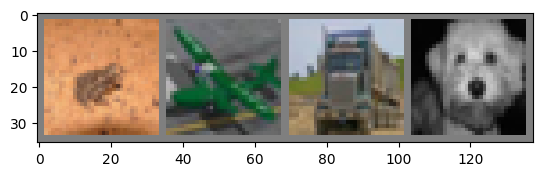

Epoch [1/5], Step [2000/12500], Loss: 2.3131
Epoch [1/5], Step [4000/12500], Loss: 2.2998
Epoch [1/5], Step [6000/12500], Loss: 2.3090
Epoch [1/5], Step [8000/12500], Loss: 2.2171
Epoch [1/5], Step [10000/12500], Loss: 2.1582
Epoch [1/5], Step [12000/12500], Loss: 2.1764
Epoch [2/5], Step [2000/12500], Loss: 2.3594
Epoch [2/5], Step [4000/12500], Loss: 2.0897
Epoch [2/5], Step [6000/12500], Loss: 1.4626
Epoch [2/5], Step [8000/12500], Loss: 1.2753
Epoch [2/5], Step [10000/12500], Loss: 1.7610
Epoch [2/5], Step [12000/12500], Loss: 2.3180
Epoch [3/5], Step [2000/12500], Loss: 1.3150
Epoch [3/5], Step [4000/12500], Loss: 1.7744
Epoch [3/5], Step [6000/12500], Loss: 2.2767
Epoch [3/5], Step [8000/12500], Loss: 1.8437
Epoch [3/5], Step [10000/12500], Loss: 1.6496
Epoch [3/5], Step [12000/12500], Loss: 1.3508
Epoch [4/5], Step [2000/12500], Loss: 1.4375
Epoch [4/5], Step [4000/12500], Loss: 1.1471
Epoch [4/5], Step [6000/12500], Loss: 1.7724
Epoch [4/5], Step [8000/12500], Loss: 1.3775
Epoc

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters 
num_epochs = 5
batch_size = 4
learning_rate = 0.001

# dataset has PILImage images of range [0, 1]. 
# We transform them to Tensors of normalized range [-1, 1]
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# CIFAR10: 60000 32x32 color images in 10 classes, with 6000 images per class
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool(F.relu(self.conv1(x)))  # -> n, 6, 14, 14
        x = self.pool(F.relu(self.conv2(x)))  # -> n, 16, 5, 5
        x = x.view(-1, 16 * 5 * 5)            # -> n, 400
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 10
        return x


model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

n_total_steps = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # origin shape: [4, 3, 32, 32] = 4, 3, 1024
        # input_layer: 3 input channels, 6 output channels, 5 kernel size
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 2000 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{n_total_steps}], Loss: {loss.item():.4f}')

print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        # max returns (value ,index)
        _, predicted = torch.max(outputs, 1)
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1

    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of {classes[i]}: {acc} %')



In [ ]:
learning_rate=0.01
n_iterations=1000